In [1]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
data = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
data.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [2]:
rename = {
    "preco": "price",
    "vendido": "sold",
    "idade_do_modelo": "model_age",
    "km_por_ano": "km_per_year"
}

data = data.rename(columns=rename)
data.head()

,price,sold,model_age,km_per_year
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [3]:
# horribly unlucky situation where the classes are ordered by default

data_unluck = data.sort_values("sold", ascending=True)
x_unluck = data_unluck[["price", "model_age", "km_per_year"]]
y_unluck = data_unluck["sold"]
data_unluck.head()

,price,sold,model_age,km_per_year
10,75668.42,0,2,22635.36710
7,65265.09,0,10,18666.73466
3,95276.14,0,3,43167.32682
2,89627.50,0,12,11440.79806
4221,64724.65,0,10,13194.97866


In [4]:
from sklearn.model_selection import cross_validate
from  sklearn.dummy  import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

model = DummyClassifier(strategy="stratified")
results = cross_validate(model, x_unluck, y_unluck, cv=10, return_train_score=False)
mean = results["test_score"].mean()
std = results["test_score"].std()
print(f"Accuracy with cross-validation, 10 = [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

Accuracy with cross-validation, 10 = [49.79, 53.45]


In [5]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED  = 301
np.random.seed(SEED)

model = DecisionTreeClassifier(max_depth=2)
results = cross_validate(model, x_unluck, y_unluck, cv=10, return_train_score=False)
mean = results["test_score"].mean()
std = results["test_score"].std()
print(f"Accuracy with cross-validation, 10 = [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

Accuracy with cross-validation, 10 = [73.26, 78.30]


In [6]:
# Generating random car model data for clustering simulation using our estimator

np.random.seed(SEED)
data["model"] = data.model_age + np.random.randint(-2, 3, size=10000)
data.model = data.model + abs(data.model.min()) + 1
data.head()

,price,sold,model_age,km_per_year,model
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [7]:
def print_results(results):
    mean = results["test_score"].mean()
    std = results["test_score"].std()
    print(f"Mean accuracy: {mean*100:.2f}")
    print(f"Accuracy interval: [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

In [8]:
# GroupKFold to analyze how the model behaves with new groups

from sklearn.model_selection import GroupKFold

SEED  = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
model = DecisionTreeClassifier(max_depth=2)
results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 75.79
Accuracy interval: [74.03, 77.56]


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED  = 301
np.random.seed(SEED)

scaler = StandardScaler()
model = SVC()

pipeline = Pipeline([('transformation',scaler), ('estimator', model)])

cv = GroupKFold(n_splits=10)
results = cross_validate(pipeline, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 76.62
Accuracy interval: [74.02, 79.22]


In [10]:
# GroupKFold to analyze how the model behaves with new groups

from sklearn.model_selection import GroupKFold

SEED  = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
model = DecisionTreeClassifier(max_depth=3)
results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 78.66
Accuracy interval: [77.21, 80.12]


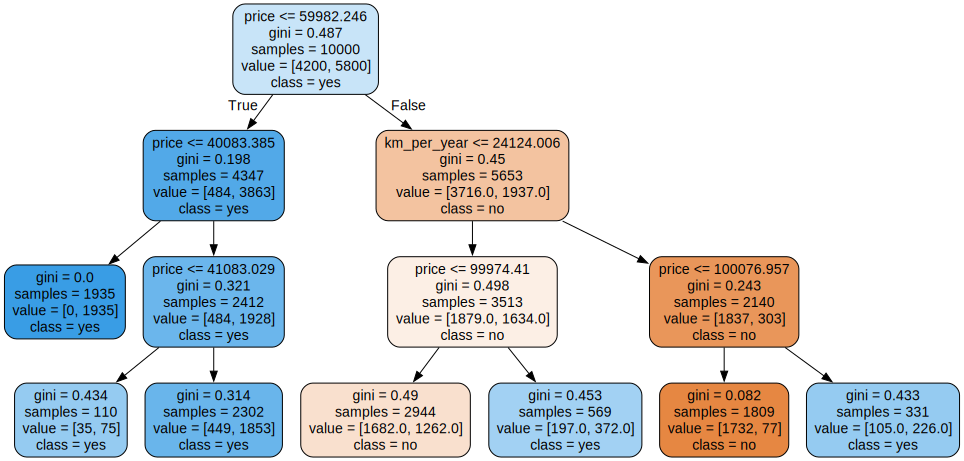

In [11]:
from sklearn.tree import export_graphviz
import graphviz

model.fit(x_unluck, y_unluck)
features = x_unluck.columns
dot_data = export_graphviz(model, out_file=None, filled=True, rounded=True, class_names=["no", "yes"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [12]:
# GroupKFold to analyze how the model behaves with new groups

from sklearn.model_selection import GroupKFold


SEED  = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits=10)
model = DecisionTreeClassifier(max_depth=10)
results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=False)
print_results(results)

Mean accuracy: 77.06
Accuracy interval: [74.99, 79.13]


# Exploring hyperparameters in 1 dimension

In [13]:
def run_tree_decision(max_depth):
    SEED  = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(max_depth=max_depth)
    results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    print(f"max_depth = {max_depth}, train = {train_score:.2f} test = {test_score:.2f}")
    table = [max_depth, train_score, test_score]
    return table

results = [run_tree_decision(i) for i in range(1, 33)]
results = pd.DataFrame(results, columns=["max_depth", "train", "test"])
results.head()
    

max_depth = 1, train = 75.79 test = 75.79
max_depth = 2, train = 75.79 test = 75.79
max_depth = 3, train = 78.76 test = 78.66
max_depth = 4, train = 78.81 test = 78.63
max_depth = 5, train = 78.96 test = 78.62
max_depth = 6, train = 79.12 test = 78.48
max_depth = 7, train = 79.37 test = 78.25
max_depth = 8, train = 79.74 test = 78.19
max_depth = 9, train = 80.33 test = 77.76
max_depth = 10, train = 81.01 test = 77.06
max_depth = 11, train = 81.85 test = 76.55
max_depth = 12, train = 82.77 test = 75.99
max_depth = 13, train = 83.81 test = 75.60
max_depth = 14, train = 84.84 test = 75.46
max_depth = 15, train = 85.98 test = 75.06
max_depth = 16, train = 87.03 test = 74.87
max_depth = 17, train = 88.11 test = 74.74
max_depth = 18, train = 89.16 test = 74.31
max_depth = 19, train = 90.17 test = 74.02
max_depth = 20, train = 91.21 test = 73.57
max_depth = 21, train = 92.12 test = 73.21
max_depth = 22, train = 93.01 test = 73.32
max_depth = 23, train = 93.80 test = 72.94
max_depth = 24, trai

,max_depth,train,test
0,1,75.791294,75.794020
1,2,75.791294,75.794020
2,3,78.756840,78.663128
3,4,78.813487,78.632070
4,5,78.955616,78.623011


<Axes: xlabel='max_depth', ylabel='train'>

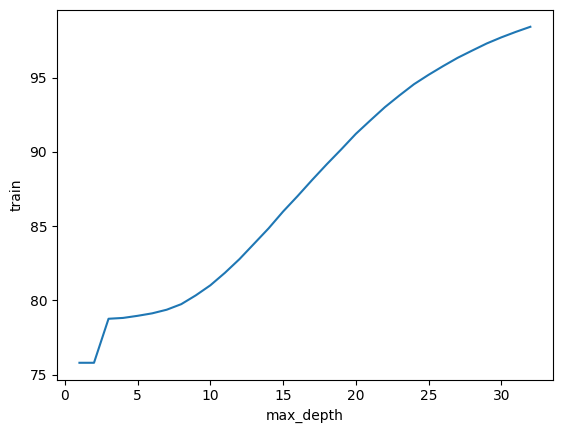

In [14]:
import seaborn as sns

sns.lineplot(x="max_depth", y="train", data=results)

# OVERFIT

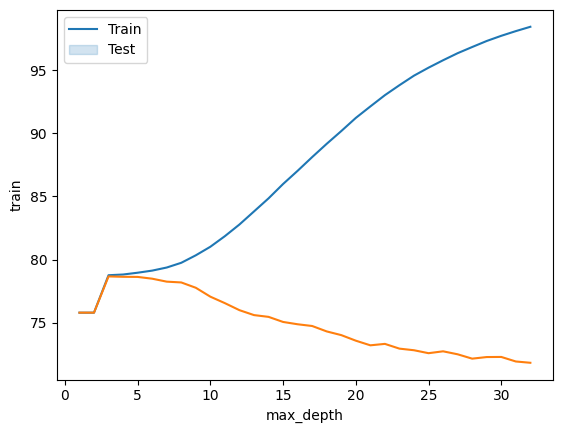

In [15]:
import matplotlib.pyplot as plt

sns.lineplot(x="max_depth", y="train", data=results)
sns.lineplot(x="max_depth", y="test", data=results)
plt.legend(["Train", "Test"])

In [16]:
results.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.756840,78.663128
3,4,78.813487,78.632070
4,5,78.955616,78.623011
5,6,79.122453,78.482508
6,7,79.366863,78.248483


# Exploring hyperparameters in 2 dimensions

In [17]:
def run_tree_decision(max_depth, min_samples_leaf):
    SEED  = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf)
    results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=True)
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    print(f"max_depth = {max_depth},  min_samples_leaf = {min_samples_leaf}, train = {train_score:.2f} test = {test_score:.2f}")
    table = [max_depth, min_samples_leaf, train_score, test_score]
    return table

def search():
    results = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            table = run_tree_decision(max_depth, min_samples_leaf)
            results.append(table)
    results = pd.DataFrame(results, columns=["max_depth", "min_samples_leaf", "train", "test"])
    return results

results = search()
results.head() 

max_depth = 1,  min_samples_leaf = 32, train = 75.79 test = 75.79
max_depth = 1,  min_samples_leaf = 64, train = 75.79 test = 75.79
max_depth = 1,  min_samples_leaf = 128, train = 75.79 test = 75.79
max_depth = 1,  min_samples_leaf = 256, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 32, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 64, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 128, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 256, train = 75.79 test = 75.79
max_depth = 3,  min_samples_leaf = 32, train = 78.75 test = 78.70
max_depth = 3,  min_samples_leaf = 64, train = 78.75 test = 78.70
max_depth = 3,  min_samples_leaf = 128, train = 78.75 test = 78.70
max_depth = 3,  min_samples_leaf = 256, train = 78.75 test = 78.70
max_depth = 4,  min_samples_leaf = 32, train = 78.77 test = 78.64
max_depth = 4,  min_samples_leaf = 64, train = 78.75 test = 78.70
max_depth = 4,  min_samples_leaf = 128, train = 78.75 test = 78.70
max

,max_depth,min_samples_leaf,train,test
0,1,32,75.791294,75.79402
1,1,64,75.791294,75.79402
2,1,128,75.791294,75.79402
3,1,256,75.791294,75.79402
4,2,32,75.791294,75.79402


In [18]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
11,3,256,78.752392,78.702771
15,4,256,78.752392,78.702771
14,4,128,78.752392,78.702771
13,4,64,78.752392,78.702771
9,3,64,78.752392,78.702771


In [19]:
corr = results.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.529561,0.035671
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.416732,0.475520
train,5.295613e-01,-4.167318e-01,1.000000,0.108912
test,3.567066e-02,4.755197e-01,0.108912,1.000000


<Axes: >

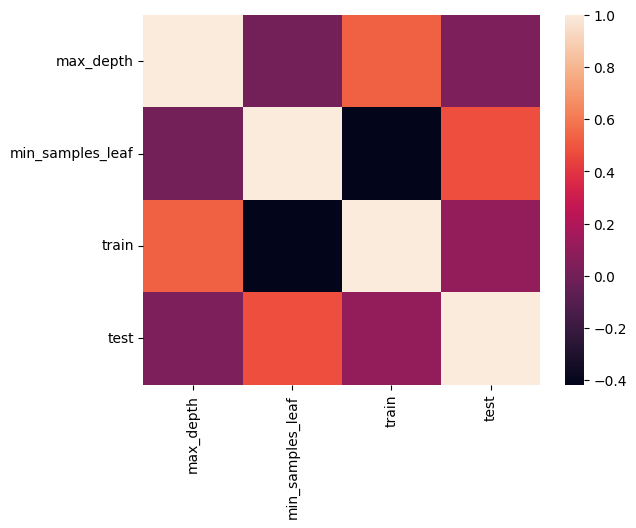

In [20]:
sns.heatmap(corr)

array([[<Axes: xlabel='max_depth', ylabel='max_depth'>,
        <Axes: xlabel='min_samples_leaf', ylabel='max_depth'>,
        <Axes: xlabel='train', ylabel='max_depth'>,
        <Axes: xlabel='test', ylabel='max_depth'>],
       [<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>,
        <Axes: xlabel='min_samples_leaf', ylabel='min_samples_leaf'>,
        <Axes: xlabel='train', ylabel='min_samples_leaf'>,
        <Axes: xlabel='test', ylabel='min_samples_leaf'>],
       [<Axes: xlabel='max_depth', ylabel='train'>,
        <Axes: xlabel='min_samples_leaf', ylabel='train'>,
        <Axes: xlabel='train', ylabel='train'>,
        <Axes: xlabel='test', ylabel='train'>],
       [<Axes: xlabel='max_depth', ylabel='test'>,
        <Axes: xlabel='min_samples_leaf', ylabel='test'>,
        <Axes: xlabel='train', ylabel='test'>,
        <Axes: xlabel='test', ylabel='test'>]], dtype=object)

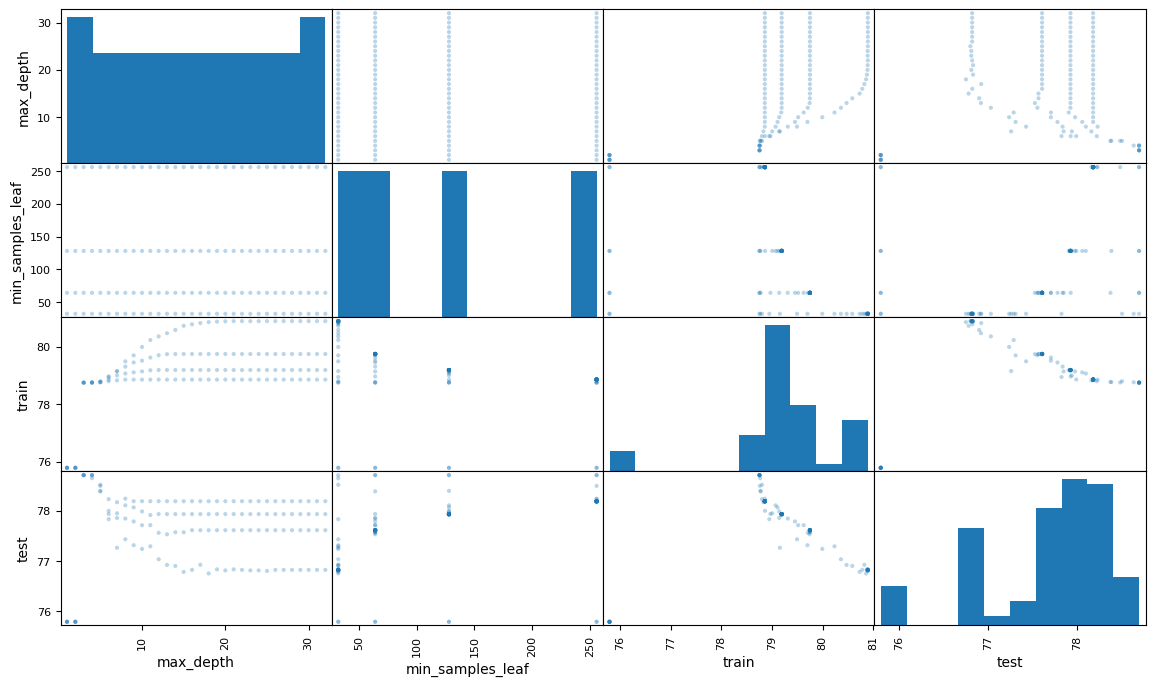

In [21]:
pd.plotting.scatter_matrix(results, figsize=(14, 8), alpha=0.3)

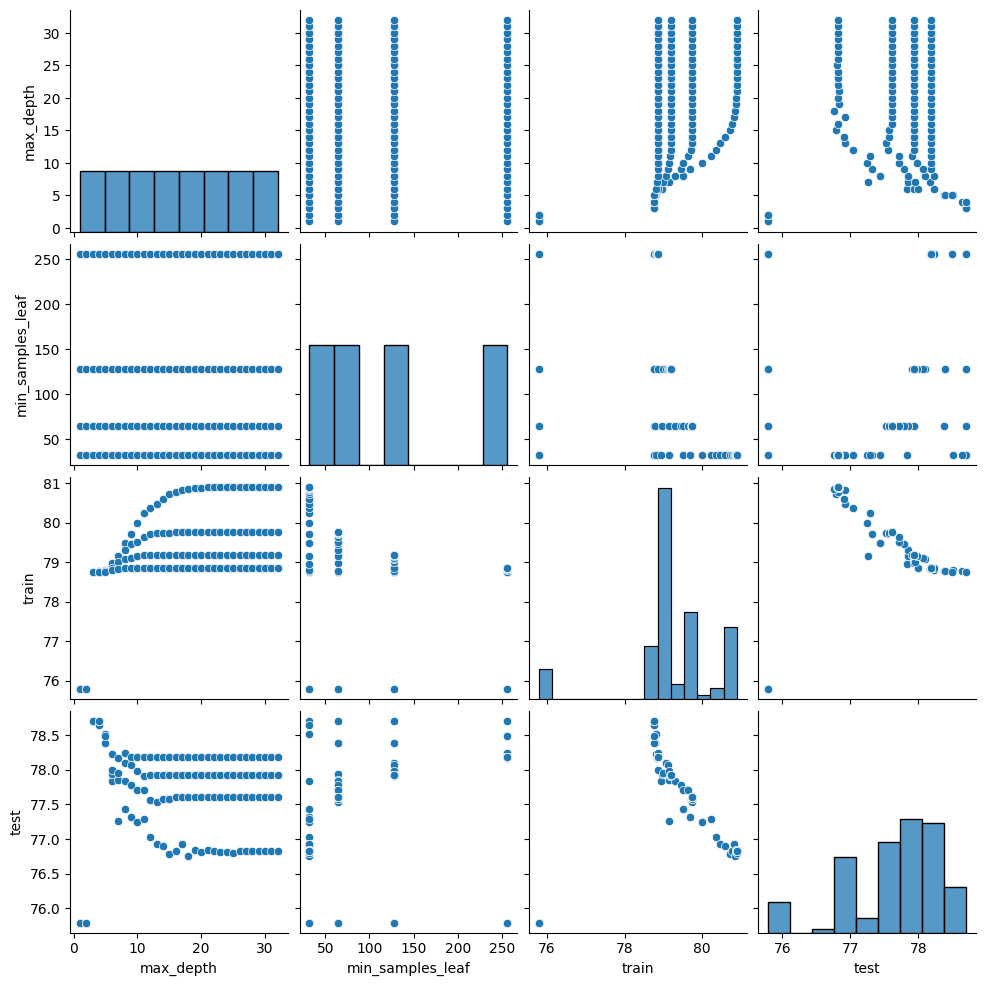

In [22]:
sns.pairplot(results)

<Axes: >

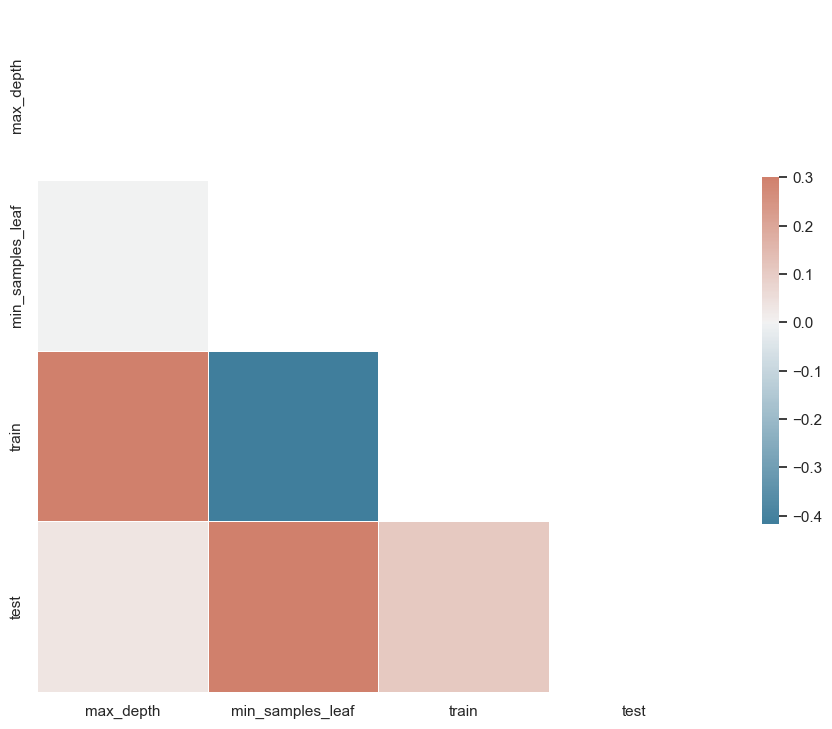

In [23]:
sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [24]:
def search():
    results = []
    for max_depth in range(1,33):
        for min_samples_leaf in [128, 192, 256, 512]:
            table = run_tree_decision(max_depth, min_samples_leaf)
            results.append(table)
    results = pd.DataFrame(results, columns=["max_depth", "min_samples_leaf", "train", "test"])
    return results

results = search()
results.head() 

max_depth = 1,  min_samples_leaf = 128, train = 75.79 test = 75.79
max_depth = 1,  min_samples_leaf = 192, train = 75.79 test = 75.79
max_depth = 1,  min_samples_leaf = 256, train = 75.79 test = 75.79
max_depth = 1,  min_samples_leaf = 512, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 128, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 192, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 256, train = 75.79 test = 75.79
max_depth = 2,  min_samples_leaf = 512, train = 75.79 test = 75.79
max_depth = 3,  min_samples_leaf = 128, train = 78.75 test = 78.70
max_depth = 3,  min_samples_leaf = 192, train = 78.75 test = 78.70
max_depth = 3,  min_samples_leaf = 256, train = 78.75 test = 78.70
max_depth = 3,  min_samples_leaf = 512, train = 77.53 test = 77.51
max_depth = 4,  min_samples_leaf = 128, train = 78.75 test = 78.70
max_depth = 4,  min_samples_leaf = 192, train = 78.75 test = 78.70
max_depth = 4,  min_samples_leaf = 256, train = 78.75 test = 7

,max_depth,min_samples_leaf,train,test
0,1,128,75.791294,75.79402
1,1,192,75.791294,75.79402
2,1,256,75.791294,75.79402
3,1,512,75.791294,75.79402
4,2,128,75.791294,75.79402


<Axes: >

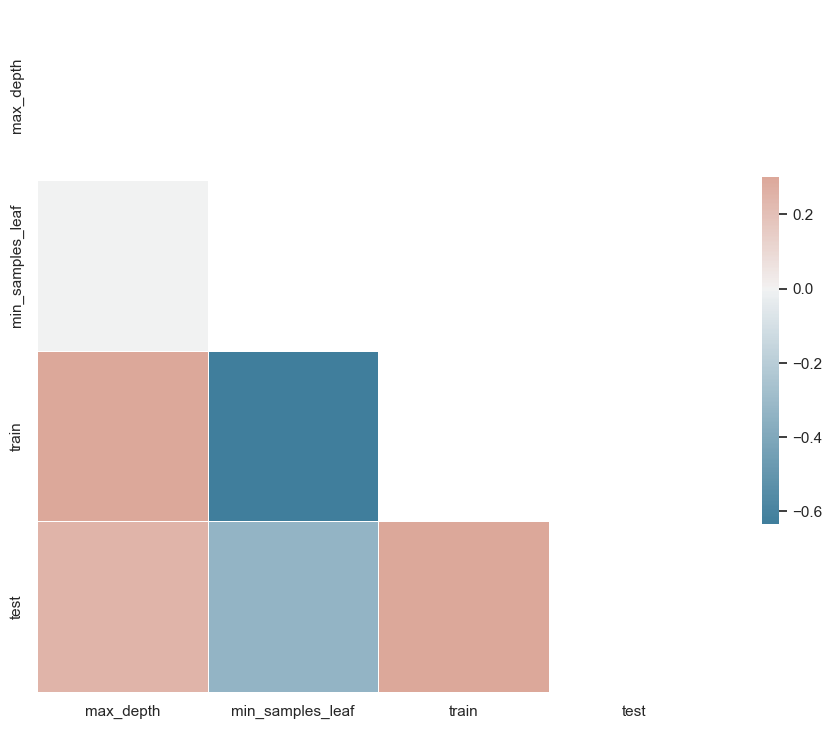

In [25]:
corr = results.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [26]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
12,4,128,78.752392,78.702771
10,3,256,78.752392,78.702771
13,4,192,78.752392,78.702771
14,4,256,78.752392,78.702771
9,3,192,78.752392,78.702771


# Exploring hyperparameters in 3 dimensions

In [27]:
def run_tree_decision(max_depth, min_samples_leaf, min_samples_split):
    SEED  = 301
    np.random.seed(SEED)

    cv = GroupKFold(n_splits=10)
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf= min_samples_leaf, min_samples_split=min_samples_split)
    results = cross_validate(model, x_unluck, y_unluck, cv=cv, groups = data.model, return_train_score=True)
    fit_time = results["fit_time"].mean()
    score_time = results["score_time"].mean()
    train_score = results['train_score'].mean()*100
    test_score = results['test_score'].mean()*100
    table = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
    return table

def search():
    results = []
    for max_depth in range(1,33):
        for min_samples_leaf in [32, 64, 128, 256]:
            for min_samples_split in [32, 128, 256]:
                table = run_tree_decision(max_depth, min_samples_leaf, min_samples_split)
                results.append(table)
    results = pd.DataFrame(results, columns=["max_depth", "min_samples_leaf", "min_samples_split", "train", "test", "fit_time", "score_time"])
    return results

results = search()
results.head() 

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791294,75.79402,0.005602,0.001505
1,1,32,128,75.791294,75.79402,0.004723,0.001213
2,1,32,256,75.791294,75.79402,0.004562,0.001002
3,1,64,32,75.791294,75.79402,0.004404,0.001733
4,1,64,128,75.791294,75.79402,0.005117,0.001302


<Axes: >

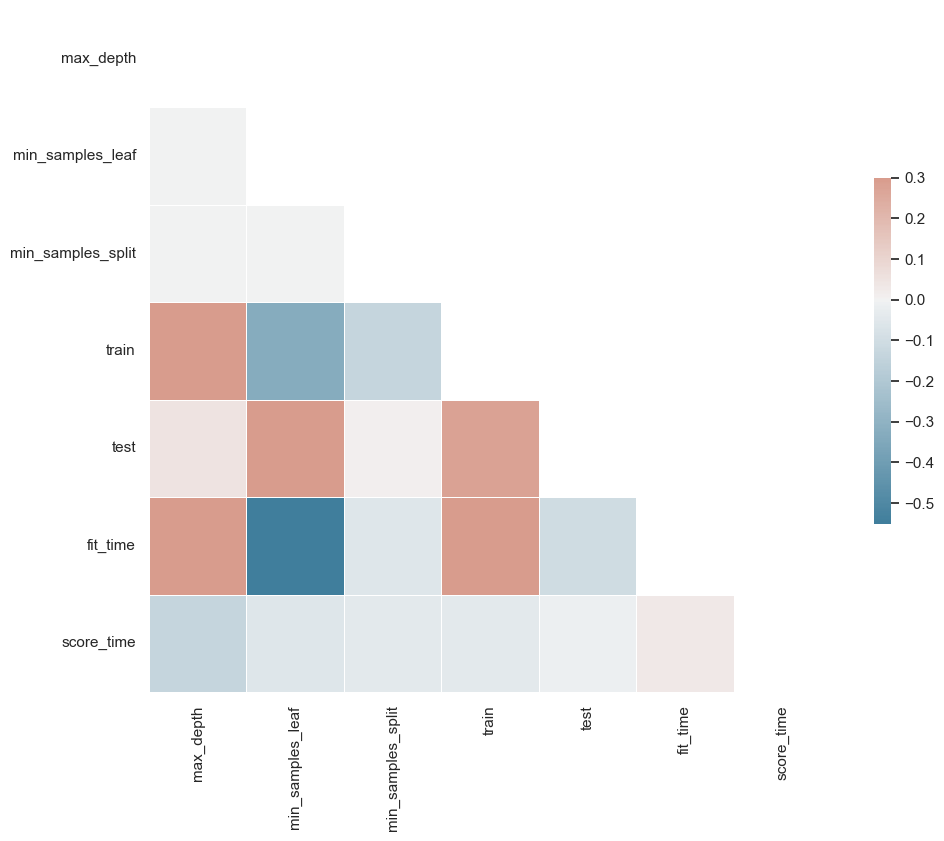

In [28]:
corr = results.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [29]:
results.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
44,4,128,256,78.752392,78.702771,0.011118,0.001300
45,4,256,32,78.752392,78.702771,0.011116,0.001608
46,4,256,128,78.752392,78.702771,0.011408,0.001602
39,4,64,32,78.752392,78.702771,0.013208,0.001690
41,4,64,256,78.752392,78.702771,0.011806,0.001803


# Exploring hyperparameter space with GridSearchCV

In [30]:
from sklearn.model_selection import GridSearchCV

SEED = 301
np.random.seed(SEED)

parameter_space = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "criterion": ["gini", "entropy"]
}

search = GridSearchCV(DecisionTreeClassifier(),
                      parameter_space,
                      cv=GroupKFold(n_splits=10))
search.fit(x_unluck, y_unluck, groups=data.model)
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009959,0.001499,0.001597,0.000657,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.780971,...,0.791045,0.784195,0.783865,0.783047,0.793939,0.795918,0.774345,0.787028,0.00685,1
1,0.009204,0.000600,0.001597,0.000488,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.780971,...,0.791045,0.784195,0.783865,0.783047,0.793939,0.795918,0.774345,0.787028,0.00685,1
2,0.009199,0.000733,0.001463,0.000602,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.780971,...,0.791045,0.784195,0.783865,0.783047,0.793939,0.795918,0.774345,0.787028,0.00685,1
3,0.009229,0.000403,0.001296,0.000458,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.780971,...,0.791045,0.784195,0.783865,0.783047,0.793939,0.795918,0.774345,0.787028,0.00685,1
4,0.009135,0.000494,0.001499,0.000499,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.780971,...,0.791045,0.784195,0.783865,0.783047,0.793939,0.795918,0.774345,0.787028,0.00685,1


In [31]:
print(search.best_params_)
print(search.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.70277092772066


In [32]:
best_estimator = search.best_estimator_
best_estimator

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [33]:
from sklearn.metrics import accuracy_score

# avoid this approach as it will be overly optimistic

predictions = best_estimator.predict(x_unluck)
accuracy = accuracy_score(predictions, y_unluck) *100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 78.75%


# Nested cross-validation and validating the best model

In [34]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(search, x_unluck, y_unluck, cv=GroupKFold(n_splits=10), groups=data.model)


# Unfortunately, pandas does not support nested validation with Group K-Fold, so we cannot predict results for new groups

In [35]:
from sklearn.model_selection import KFold

SEED = 301
np.random.seed(SEED)

parameter_space = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "criterion": ["gini", "entropy"]
}

search = GridSearchCV(DecisionTreeClassifier(),
                      parameter_space,
                      cv=KFold(n_splits=5, shuffle=True))
search.fit(x_unluck, y_unluck)
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009999,0.001789,0.002001,0.000001,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
1,0.008990,0.000634,0.001400,0.000489,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
2,0.008568,0.000744,0.001407,0.000798,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
3,0.009208,0.001183,0.001210,0.000406,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
4,0.008789,0.000686,0.001999,0.000633,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1


In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(search, x_unluck, y_unluck, cv=KFold(n_splits=5, shuffle=True))
scores


array([0.7915, 0.781 , 0.79  , 0.7815, 0.791 ])

In [37]:
def print_score(scores):
    mean = scores.mean()
    std = scores.std()
    print(f"Mean accuracy: {mean*100:.2f}")
    print(f"Accuracy interval: [{(mean - 2*std)*100:.2f}, {(mean + 2*std)*100:.2f}]")

In [38]:
print_score(scores)

Mean accuracy: 78.70
Accuracy interval: [77.76, 79.64]


In [39]:
best = search.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)


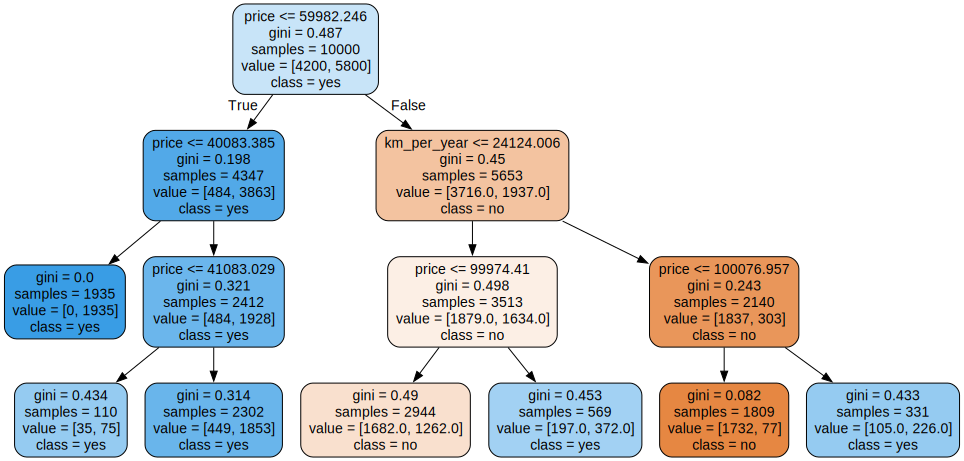

In [40]:
from sklearn.tree import export_graphviz
import graphviz

features = x_unluck.columns
dot_data = export_graphviz(best, out_file=None, filled=True, rounded=True, class_names=["no", "yes"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Random search

In [41]:
from sklearn.model_selection import RandomizedSearchCV

SEED = 301
np.random.seed(SEED)

parameter_space = {
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "criterion": ["gini", "entropy"]
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                      parameter_space,
                      n_iter=16,
                      cv=KFold(n_splits=5, shuffle=True),
                      random_state=SEED)
search.fit(x_unluck, y_unluck)
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.016399,0.002871,0.002001,0.000632,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.7855,0.786,0.782,0.798,0.774,0.7851,0.007749,15
1,0.008139,0.000727,0.001601,0.000490,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
2,0.007614,0.000489,0.001400,0.000489,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
3,0.016718,0.001107,0.001601,0.000480,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1
4,0.015486,0.000822,0.001793,0.000398,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.7855,0.786,0.791,0.798,0.774,0.7869,0.007864,1


In [42]:
scores = cross_val_score(search, x_unluck, y_unluck, cv=KFold(n_splits=5, shuffle=True))
print_score(scores)

Mean accuracy: 78.69
Accuracy interval: [77.71, 79.67]


In [43]:
best = search.best_estimator_
print(best)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=64)


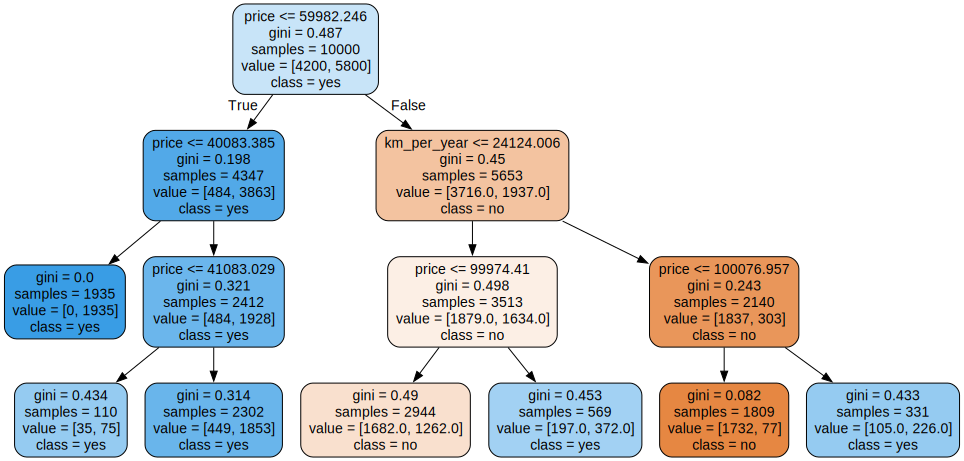

In [44]:
features = x_unluck.columns
dot_data = export_graphviz(best, out_file=None, filled=True, rounded=True, class_names=["no", "yes"], feature_names=features)
graph = graphviz.Source(dot_data)
graph

# Customizing the hyperparameter space

In [45]:
from scipy.stats import randint

SEED = 301
np.random.seed(SEED)

parameter_space = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                      parameter_space,
                      n_iter=16,
                      cv=KFold(n_splits=5, shuffle=True),
                      random_state=SEED)
search.fit(x_unluck, y_unluck)
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011400,0.000491,0.001599,0.000490,entropy,3.0,71,100,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.7855,0.7860,0.7910,0.798,0.7740,0.7869,0.007864,1
1,0.016218,0.000749,0.002113,0.000217,gini,15.0,93,111,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7645,0.7785,0.7735,0.787,0.7735,0.7754,0.007351,13
2,0.014420,0.000790,0.001405,0.000485,gini,20.0,124,88,"{'criterion': 'gini', 'max_depth': 20, 'min_sa...",0.7695,0.7805,0.7730,0.780,0.7755,0.7757,0.004179,10
3,0.017780,0.000708,0.001806,0.000403,gini,NaN,46,62,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.7640,0.7690,0.7755,0.771,0.7675,0.7694,0.003813,16
4,0.013980,0.000044,0.002288,0.000396,gini,15.0,126,84,"{'criterion': 'gini', 'max_depth': 15, 'min_sa...",0.7690,0.7805,0.7730,0.780,0.7755,0.7756,0.004329,11


In [46]:
scores = cross_val_score(search, x_unluck, y_unluck, cv=KFold(n_splits=5, shuffle=True))
print_score(scores)
best = search.best_estimator_
print(best)

Mean accuracy: 78.69
Accuracy interval: [77.71, 79.67]
DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=71,
                       min_samples_split=100)


In [47]:
results_sorted_by_mean = results.sort_values("mean_test_score", ascending=False)
for i, row in results_sorted_by_mean.iterrows():
    print(f"{row.mean_test_score:.3f} +- {row.std_test_score*2:.3f} {row.params}")

0.787 +- 0.016 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +- 0.016 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 73, 'min_samples_split': 72}
0.785 +- 0.015 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.780 +- 0.014 {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 104, 'min_samples_split': 88}
0.778 +- 0.015 {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 108, 'min_samples_split': 110}
0.777 +- 0.013 {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 103, 'min_samples_split': 96}
0.777 +- 0.014 {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 100, 'min_samples_split': 84}
0.777 +- 0.012 {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 74, 'min_samples_split': 58}
0.776 +- 0.014 {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 101, 'min_samples_split': 52}
0.776 +- 0.008 {'criterion': 'gini', 'max_depth': 20, '

# A deeper exploration in a random manner

In [48]:
from scipy.stats import randint

SEED = 564
np.random.seed(SEED)

parameter_space = {
    "max_depth": [3, 5, 10, 15, 20, 30, None],
    "min_samples_split": randint(32, 128),
    "min_samples_leaf": randint(32, 128),
    "criterion": ["gini", "entropy"]
}

search = RandomizedSearchCV(DecisionTreeClassifier(),
                      parameter_space,
                      n_iter=64,
                      cv=KFold(n_splits=5, shuffle=True),
                      random_state=SEED)
search.fit(x_unluck, y_unluck)
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021821,0.000744,0.002385,0.000808,entropy,NaN,84,103,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7730,0.7880,0.7690,0.7695,0.7640,0.7727,0.008171,32
1,0.008400,0.000501,0.001399,0.000490,gini,3.0,53,60,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.7830,0.7925,0.7875,0.7905,0.7810,0.7869,0.004352,1
2,0.014598,0.000500,0.001602,0.000494,gini,30.0,118,61,"{'criterion': 'gini', 'max_depth': 30, 'min_sa...",0.7660,0.7790,0.7650,0.7660,0.7680,0.7688,0.005192,57
3,0.024806,0.001157,0.001594,0.000484,entropy,NaN,53,85,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.7810,0.7765,0.7665,0.7720,0.7605,0.7713,0.007229,44
4,0.017608,0.001746,0.001599,0.000488,gini,10.0,44,67,"{'criterion': 'gini', 'max_depth': 10, 'min_sa...",0.7825,0.7745,0.7660,0.7775,0.7635,0.7728,0.007096,31


In [49]:
results_sorted_by_mean = results.sort_values("mean_test_score", ascending=False)
for i, row in results_sorted_by_mean.iterrows():
    print(f"{row.mean_test_score:.3f} +- {row.std_test_score*2:.3f} {row.params}")

0.787 +- 0.009 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 60}
0.787 +- 0.009 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 49, 'min_samples_split': 58}
0.787 +- 0.009 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 58, 'min_samples_split': 118}
0.787 +- 0.009 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 61, 'min_samples_split': 86}
0.787 +- 0.009 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 122, 'min_samples_split': 117}
0.787 +- 0.009 {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 38, 'min_samples_split': 113}
0.787 +- 0.009 {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 33, 'min_samples_split': 77}
0.785 +- 0.009 {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 45, 'min_samples_split': 65}
0.785 +- 0.009 {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 39, 'min_samples_split': 73}
0.783 +- 0.013 {'criterion': 'gini', 'max_depth': 5, 'min_samples_

In [50]:
scores = cross_val_score(search, x_unluck, y_unluck, cv=KFold(n_splits=5, shuffle=True))
print_score(scores)
best = search.best_estimator_
print(best)

Mean accuracy: 78.61
Accuracy interval: [76.86, 80.36]
DecisionTreeClassifier(max_depth=3, min_samples_leaf=53, min_samples_split=60)


# Comparing GridSearchCV with RandomizedSearch

In [51]:
from sklearn.ensemble import RandomForestClassifier
import time

SEED = 301
np.random.seed(SEED)

parameter_space = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
search = GridSearchCV(RandomForestClassifier(),
                      parameter_space,
                      cv=KFold(n_splits=5, shuffle=True))
search.fit(x_unluck, y_unluck, groups=data.model)
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")

results = pd.DataFrame(search.cv_results_)
results.head()

c:\Users\joi00\Desktop\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Time 167.15 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033799,0.006305,0.003401,4.913451e-04,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7625,0.7335,0.7795,0.7490,0.7598,0.016851,137
1,0.291598,0.007336,0.009797,9.791304e-04,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7595,0.7790,0.7865,0.7660,0.7713,0.009913,94
2,0.030606,0.001349,0.002000,3.568323e-07,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7770,0.7780,0.7530,0.7860,0.7635,0.7715,0.011739,91
3,0.278991,0.002616,0.009196,4.053938e-04,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7560,0.7565,0.7790,0.7870,0.7660,0.7689,0.012314,111
4,0.028403,0.001008,0.002005,9.742660e-06,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7750,0.7420,0.7440,0.7760,0.7650,0.7604,0.014732,134


In [52]:
results_sorted_by_mean = results.sort_values("mean_test_score", ascending=False)
for i, row in results_sorted_by_mean[:5].iterrows():
    print(f"{row.mean_test_score:.3f} +- {row.std_test_score*2:.3f} {row.params}")

0.781 +- 0.017 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 32, 'n_estimators': 10}
0.780 +- 0.018 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 32, 'n_estimators': 10}
0.780 +- 0.011 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +- 0.021 {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.777 +- 0.018 {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 100}


In [ ]:
tic = time.time()
scores = cross_val_score(search, x_unluck, y_unluck, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")

print_score(scores)
best = search.best_estimator_
print(best)

In [54]:
SEED = 301
np.random.seed(SEED)

parameter_space = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
search = RandomizedSearchCV(RandomForestClassifier(),
                      parameter_space,
                      n_iter= 20,
                      cv=KFold(n_splits=5, shuffle=True))
search.fit(x_unluck, y_unluck, groups=data.model)
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")

results = pd.DataFrame(search.cv_results_)
results.head()

c:\Users\joi00\Desktop\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Time 23.14 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.343994,0.026843,0.009406,4.842104e-04,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7795,0.762,0.7735,0.7760,0.7830,0.7748,0.007160,6
1,0.045796,0.003172,0.002610,4.980458e-04,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7640,0.755,0.7665,0.7725,0.7775,0.7671,0.007664,13
2,0.465810,0.023404,0.012591,8.021016e-04,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7815,0.763,0.7745,0.7735,0.7815,0.7748,0.006794,7
3,0.029594,0.001493,0.002000,6.217196e-07,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7640,0.755,0.7360,0.7250,0.7755,0.7511,0.018364,20
4,0.043998,0.002608,0.002201,4.002337e-04,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7865,0.762,0.7515,0.7320,0.7815,0.7627,0.019941,17


In [55]:
results_sorted_by_mean = results.sort_values("mean_test_score", ascending=False)
for i, row in results_sorted_by_mean[:5].iterrows():
    print(f"{row.mean_test_score:.3f} +- {row.std_test_score*2:.3f} {row.params}")

0.777 +- 0.024 {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'entropy', 'bootstrap': False}
0.775 +- 0.010 {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.775 +- 0.015 {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.775 +- 0.014 {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}
0.775 +- 0.014 {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}


In [56]:
tic = time.time()
scores = cross_val_score(search, x_unluck, y_unluck, cv=KFold(n_splits=5, shuffle=True))
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")

print_score(scores)
best = search.best_estimator_
print(best)

Time 93.74 seconds
Mean accuracy: 76.88
Accuracy interval: [74.93, 78.83]
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=3,
                       min_samples_leaf=64, min_samples_split=32,
                       n_estimators=10)


In [57]:
SEED = 301
np.random.seed(SEED)

parameter_space = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

tic = time.time()
search = RandomizedSearchCV(RandomForestClassifier(),
                      parameter_space,
                      n_iter= 80,
                      cv=KFold(n_splits=5, shuffle=True))
search.fit(x_unluck, y_unluck, groups=data.model)
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")

results = pd.DataFrame(search.cv_results_)
results.head()

c:\Users\joi00\Desktop\Machine Learning\venv\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Time 93.16 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.347015,0.021414,0.009423,0.000476,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7795,0.762,0.7735,0.7760,0.7830,0.7748,0.007160,25
1,0.045995,0.002209,0.002609,0.000499,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7640,0.755,0.7665,0.7725,0.7775,0.7671,0.007664,63
2,0.482358,0.011905,0.013267,0.000319,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7815,0.763,0.7745,0.7735,0.7815,0.7748,0.006794,27
3,0.033357,0.000597,0.002586,0.000479,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7640,0.755,0.7360,0.7250,0.7755,0.7511,0.018364,79
4,0.050858,0.003365,0.002599,0.000800,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7865,0.762,0.7515,0.7320,0.7815,0.7627,0.019941,70


In [58]:
results_sorted_by_mean = results.sort_values("mean_test_score", ascending=False)
for i, row in results_sorted_by_mean[:5].iterrows():
    print(f"{row.mean_test_score:.3f} +- {row.std_test_score*2:.3f} {row.params}")

0.780 +- 0.020 {'n_estimators': 10, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
0.778 +- 0.018 {'n_estimators': 10, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': False}
0.778 +- 0.019 {'n_estimators': 10, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.777 +- 0.019 {'n_estimators': 100, 'min_samples_split': 128, 'min_samples_leaf': 64, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.777 +- 0.019 {'n_estimators': 10, 'min_samples_split': 128, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}


# When cross-validation is not possible

In [59]:
# 0.6 train
# 0.2 test
# 0.2 validation

from sklearn.model_selection import train_test_split

SEED = 301
np.random.seed(SEED)

x_train_test, x_validation, y_train_test, y_validation = train_test_split(x_unluck, y_unluck, test_size=0.2, shuffle=True, stratify=y_unluck)

print(x_train_test.shape)
print(x_validation.shape)
print(y_train_test.shape)
print(y_validation.shape)

(8000, 3)
(2000, 3)
(8000,)
(2000,)


In [60]:
from sklearn.model_selection import StratifiedShuffleSplit

parameter_space = {
    "n_estimators": [10, 100],
    "max_depth": [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32,64, 128],
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits=1, test_size=0.25)

tic = time.time()
search = RandomizedSearchCV(RandomForestClassifier(),
                      parameter_space,
                      n_iter= 5,
                      cv=split)
search.fit(x_train_test, y_train_test)
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")

results = pd.DataFrame(search.cv_results_)
results.head()

Time 0.76 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041996,0.0,0.003003,0.0,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7655,0.7655,0.0,1
1,0.032116,0.0,0.002979,0.0,10,32,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7530,0.7530,0.0,5
2,0.029008,0.0,0.002001,0.0,10,32,128,5,gini,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7610,0.7610,0.0,4
3,0.235897,0.0,0.009030,0.0,100,64,32,3,gini,True,"{'n_estimators': 100, 'min_samples_split': 64,...",0.7645,0.7645,0.0,3
4,0.348135,0.0,0.013026,0.0,100,128,32,5,gini,False,"{'n_estimators': 100, 'min_samples_split': 128...",0.7650,0.7650,0.0,2


In [61]:
tic = time.time()
scores = cross_val_score(search, x_validation, y_validation, cv=split)
tac = time.time()
duration_time= tac - tic
print(f"Time {duration_time:.2f} seconds")
scores

Time 0.56 seconds


array([0.77])